In [56]:
import pandas as pd
import numpy as np

# open df from csv
position_250274 = pd.read_csv('USDCETH/LVR/Range_USDCETH_250274_LVR_17285193_17681193.csv')
position_515539 = pd.read_csv('USDCETH/LVR/Range_USDCETH_515539_LVR_17371593_17681193.csv')
position_520645 = pd.read_csv('USDCETH/LVR/Range_USDCETH_520645_LVR_17429193_17681193.csv')

range = pd.read_csv('USDCETH/LVR/Range_USDCETH_LVR_17285193_17673993.csv')
# in range df if upper_price and lower_price are same, set both to NA
range.loc[range['upper_price'] == range['lower_price'], ['upper_price', 'lower_price']] = np.nan

In [61]:
# combine range, position_250274, position_515539, position_520645 on date
df = pd.merge(range, position_250274, on='date', how='left', suffixes=('', '_250274'))
df = pd.merge(df, position_515539, on='date', how='left', suffixes=('', '_515539'))
df = pd.merge(df, position_520645, on='date', how='left', suffixes=('', '_520645'))
combined_df = df

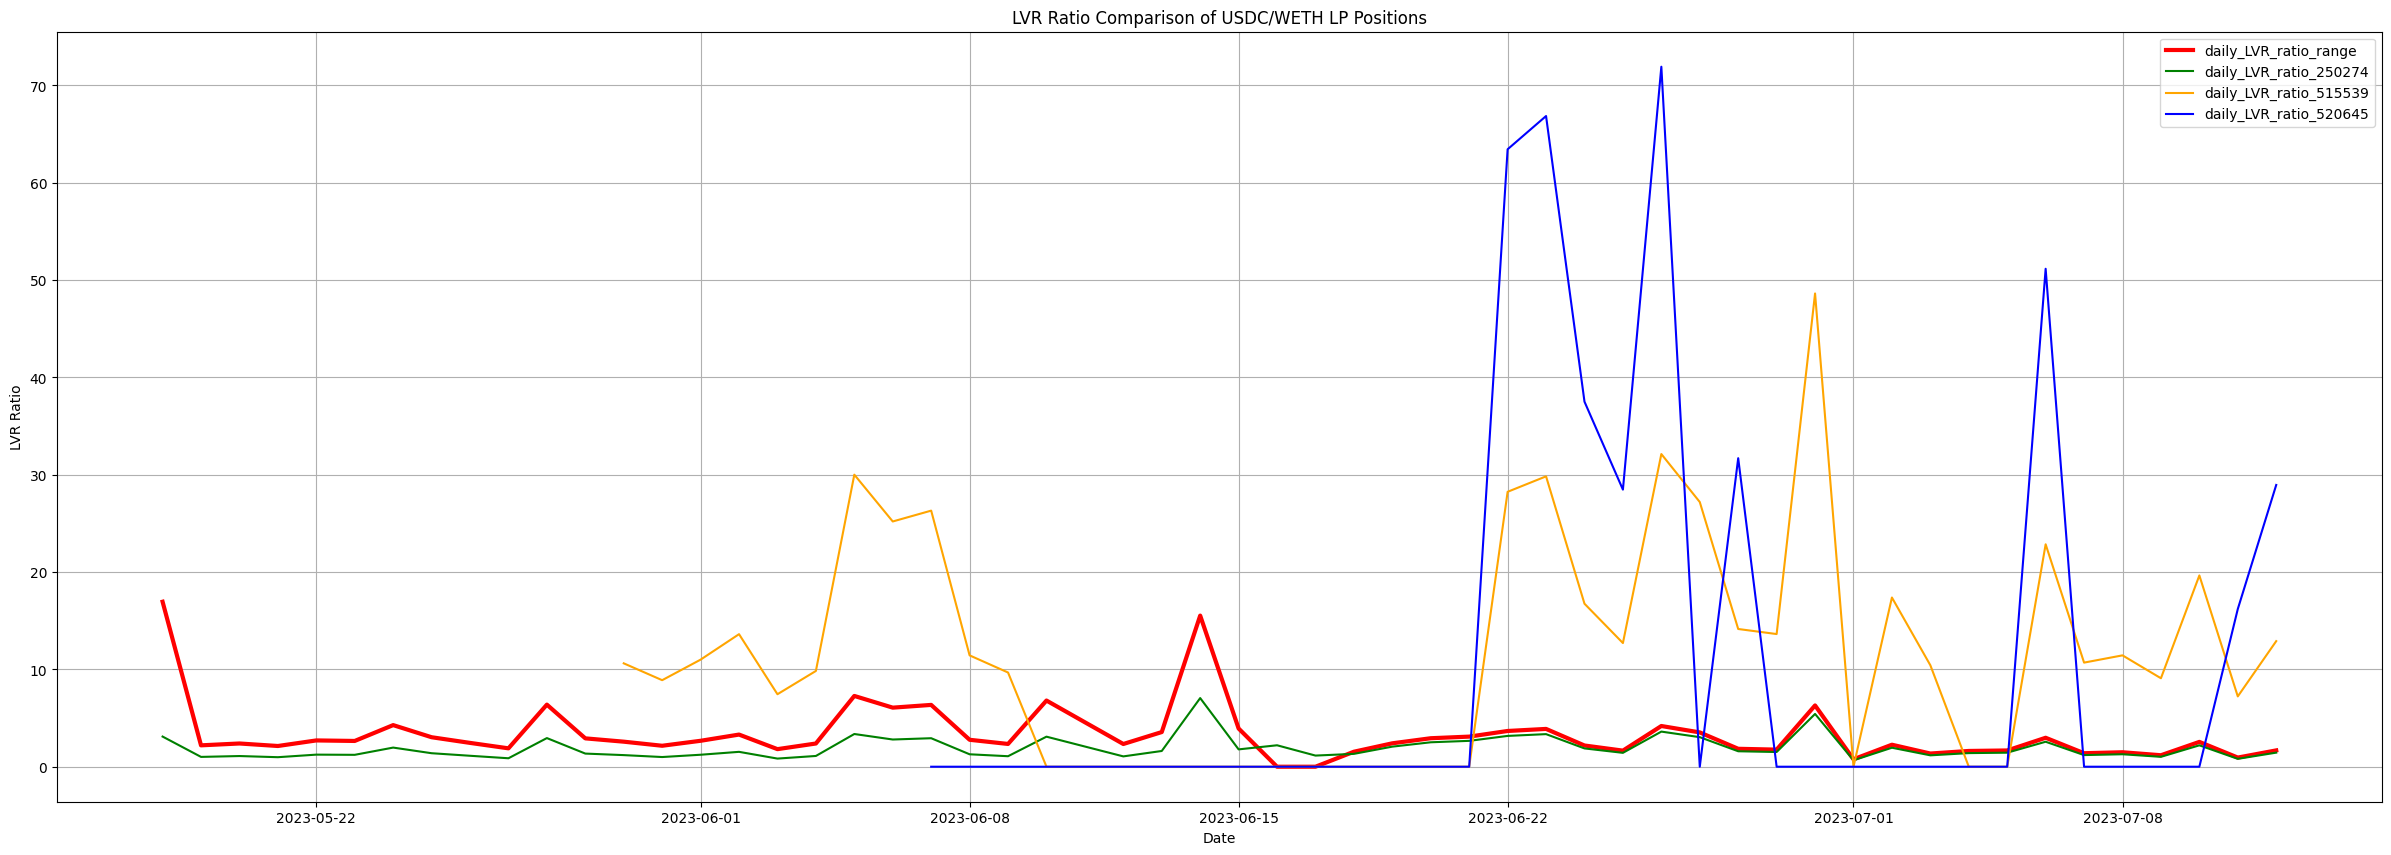

In [62]:
# plot date vs daily_LVR_ratio_range, daily_LVR_ratio_366096, daily_LVR_ratio_453456, daily_LVR_ratio_506262

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(30,10))
combined_df['date'] = pd.to_datetime(combined_df['date'])

ax.plot(combined_df['date'], combined_df['daily_LVR_ratio'], label='daily_LVR_ratio_range', color='red', linewidth=3)
ax.plot(combined_df['date'], combined_df['daily_LVR_ratio_250274'], label='daily_LVR_ratio_250274', color='green')
ax.plot(combined_df['date'], combined_df['daily_LVR_ratio_515539'], label='daily_LVR_ratio_515539', color='orange')
ax.plot(combined_df['date'], combined_df['daily_LVR_ratio_520645'], label='daily_LVR_ratio_520645', color='blue')

ax.set(xlabel='Date', ylabel='LVR Ratio', title='LVR Ratio Comparison of USDC/WETH LP Positions')
ax.grid(True)
ax.legend()

plt.show()

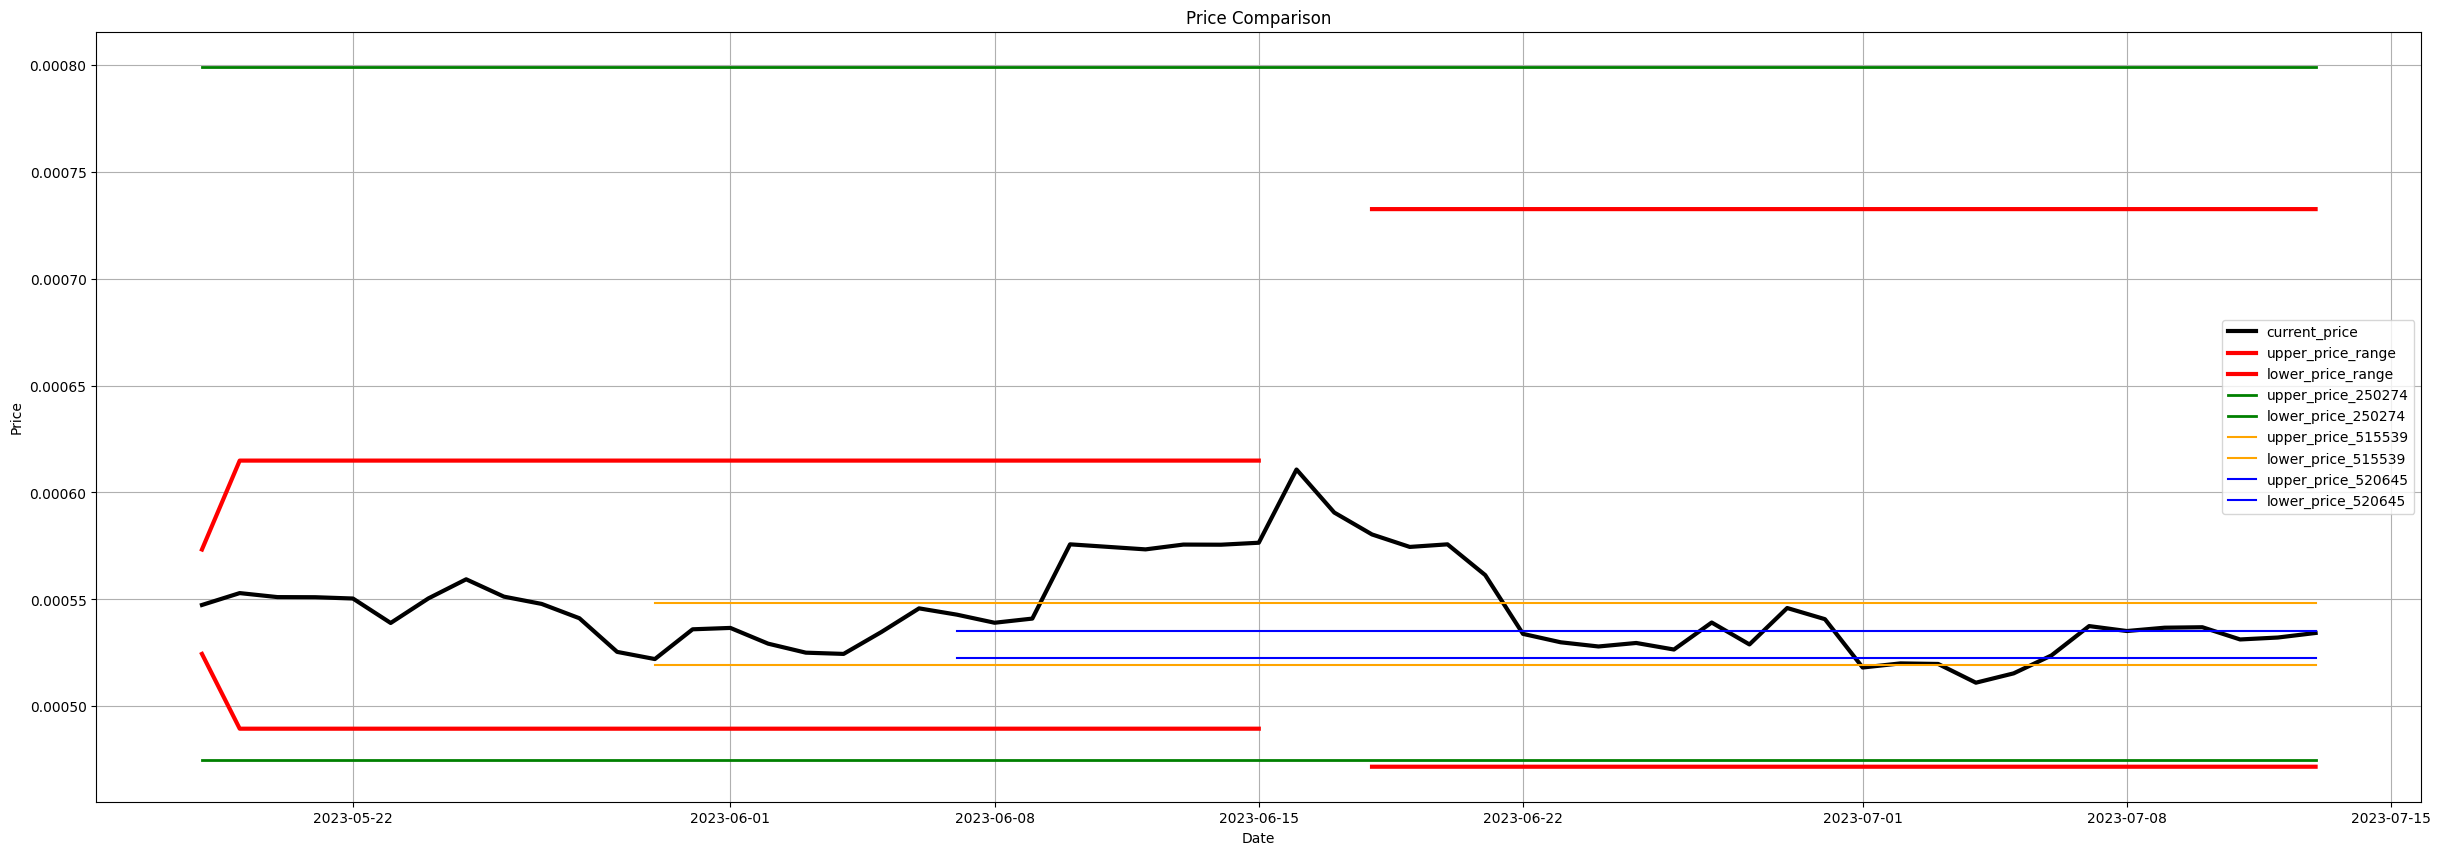

In [ ]:
fig, ax = plt.subplots(figsize=(30,10))
combined_df['date'] = pd.to_datetime(combined_df['date'])

ax.plot(combined_df['date'], combined_df['current_price'], label='current_price',color='black', linewidth=3)
ax.plot(combined_df['date'], combined_df['upper_price'], label='upper_price_range',color='red', linewidth=3)
ax.plot(combined_df['date'], combined_df['lower_price'], label='lower_price_range',color='red', linewidth=3)
ax.plot(combined_df['date'], combined_df['upper_price_250274'], label='upper_price_250274',color='green', linewidth=2)
ax.plot(combined_df['date'], combined_df['lower_price_250274'], label='lower_price_250274',color='green', linewidth=2)
ax.plot(combined_df['date'], combined_df['upper_price_515539'], label='upper_price_515539',color='orange')
ax.plot(combined_df['date'], combined_df['lower_price_515539'], label='lower_price_515539',color='orange')
ax.plot(combined_df['date'], combined_df['upper_price_520645'], label='upper_price_520645',color='blue')
ax.plot(combined_df['date'], combined_df['lower_price_520645'], label='lower_price_520645',color='blue')

ax.set(xlabel='Date', ylabel='Price', title='Price Comparison')
ax.grid(True)
ax.legend()

plt.show()